In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as ss
from easydict import EasyDict

In [2]:
from sklearn.metrics import roc_auc_score,adjusted_mutual_info_score, adjusted_rand_score

## **Bag$_i$**


**latent positive class conditional distribution**
* $z_k = 1$ indicates instance came from component k

$p^i(z_k = 1 | y=1) = \pi^i_k$

**latent negative class conditional distribution**

$p^i(z_k=1 | y=0) = \rho^i_k$

**latent positive posterior distribution**

$ p(z_k=1|x) = \gamma(z_k) = \frac{\pi^i_k \phi^1_k(x;\mu^1_k,\Sigma^1_k)}{\sum_{j=1}^{K_1} \pi^i_j \phi^1_j(x;\mu^1_j,\Sigma^1_j)} $

**positive class conditional distribution**
* K-component gaussian mixture model
* components shared across bags
* mixture weights unique to each bag

$p^i(x|y=1) = \sum_{k=1}^{K_1} \pi^i_k \phi^1_k(x;\mu^1_k,\Sigma^1_k)$

**marginal distribution**

$p(x|b_i) = p(y=1)p(x|y=1,b_i) + p(y=0)p(x|y=0,b_i)$

$p^i(x) =\alpha_i \sum_{k=1}^{K_1} \pi^i_k \phi^1_k(x;\mu^1_k,\Sigma^1_k) + (1-\alpha_i) \sum_{k=1}^{K_0}\rho^i_k \phi^0_k(x;\mu^0_k;\Sigma^0_k)$

## Bag$_i \cup$ Bag$_j$

$p(x)= w_i [(\alpha_i \sum_{k=1}^{K_1} \pi^i_k \phi^1_k(x;\mu^1_k,\Sigma^1_k) + (1-\alpha_i) \sum_{k=1}^{K_0}\rho^i_k \phi^0_k(x;\mu^0_k;\Sigma^0_k))] + w_j[\alpha_j \sum_{k=1}^{K_1} \pi^j_k \phi^1_k(x;\mu^1_k,\Sigma^1_k) + (1-\alpha_j) \sum_{k=1}^{K_0}\rho^j_k \phi^0_k(x;\mu^0_k;\Sigma^0_k)]$

## Merged Bags
* $b_i := \{c_i,m_i\}$ : bag with component and mixture sample 
* B : set of bags {$b_i$}
* positive bag weight : $w^1_i = \frac{|c_i|}{\sum_{j\in B} |c_j|}$
* unlabeled bag weight : $w^0_i = \frac{|m_i|}{\sum_{j\in B} |m_j|}$

**Positive Class Conditional Distribution**

$p(x|y=1) = \sum_{k=1}^{K_1} p(z_k=1 | y=1)p(x|z_k=1,y=1) = \sum_{k=1}^{K_1}(\sum_{i=1}^{|B|} w^1_i \pi^i_k) \phi^1_k(x;\mu^1_k,\Sigma^1_k)$

**Marginal Distribution**

$p(x) = \sum_{k=1}^{K_1} (\sum_{i=1}^{|B|}w^0_i \alpha_i \pi_k^i) \phi_k^1(x|\mu^1_k,\Sigma^1_k) + \sum_{k=1}^{K_0}(\sum_{i=1}^{|B|}w_i^0 (1-\alpha_i)\rho_k^i)\phi^0_k(x;\mu^0_k,\Sigma^0_k)$

In [16]:
class EM:
    def __init__(self, X, k):
        self.X = X
        self.k = k
        self.N,self.dim = self.X.shape
        self.initializeComponents()
        
    def initializeComponents(self):
        mins = self.X.min(0)
        maxs = self.X.max(0)
        self.mus = np.random.uniform(low=mins, high=maxs, size=(self.k,self.dim))
        self.covs = np.stack([np.eye(self.dim) for _ in range(self.k)])
        self.pi = np.random.dirichlet(np.ones(self.k))

    def E_Step(self):
        gammas = np.zeros((self.N,self.k))
        for n in range(self.N):
            for k in range(self.k):
                gammas[n,k] = self.pi[k] * ss.multivariate_normal.pdf(self.X[n],
                                                                      mean=self.mus[k],
                                                                      cov=self.covs[k])
            gammas[n] = gammas[n] / gammas[n].sum()
        self.gammas = gammas
        
    def M_Step(self):
        Nk = np.sum(self.gammas, axis=0)[:,np.newaxis]
        self.mus = np.dot(self.gammas.T, self.X) / Nk
        self.pi = np.mean(self.gammas,axis=0)
        for k in range(self.k):
            x = np.matrix(self.X - self.mus[k,:])
            gamma_diag = np.matrix(np.diag(self.gammas[:,k]))
            sigma_k = x.T * gamma_diag * x
            self.covs[k,:,:] = sigma_k / Nk[k]
            
            
    def log_likelihood(self):
        ll = 0
        for xn in self.X:
            ll += np.log(np.sum([pik * ss.multivariate_normal.pdf(xn,
                                                                  mean=muk,
                                                                  cov=covk) for pik,muk,covk in zip(self.pi,
                                                                                                    self.mus,
                                                                                                    self.covs)]))
        return ll

In [8]:
Xs = []
Ys = []
weights = []
N = 200
for _ in range(10):
    n = np.random.dirichlet((5,5,5))
    weights.append(n)
    Xs.append(np.concatenate((np.random.multivariate_normal([2.5,2.5],
                                                           np.eye(2),
                                                           size=int(N*n[0])),
                             np.random.multivariate_normal([-2.5,-1.5],
                                                           np.eye(2),
                                                           size=int(N*n[1])),
                             np.random.multivariate_normal([3,-3],
                                                           np.eye(2),
                                                           size=int(N*n[2])))))
    Ys.append(np.concatenate((np.ones(int(N*n[0])),
                              np.zeros(int(N*n[1])),
                              np.ones(int(N * n[2])) * -1)))

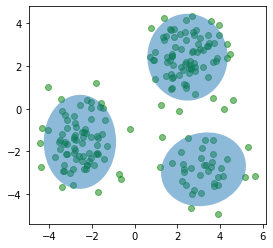

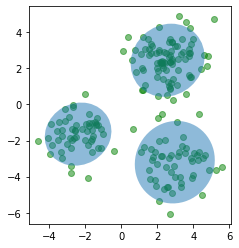

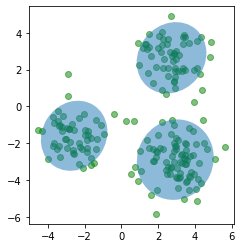

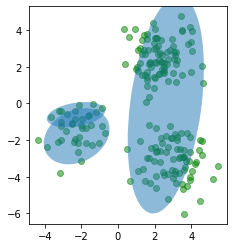

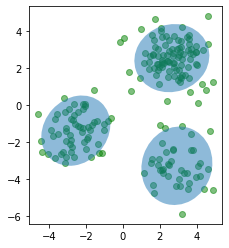

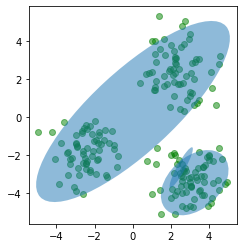

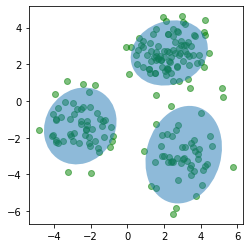

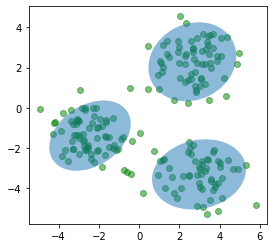

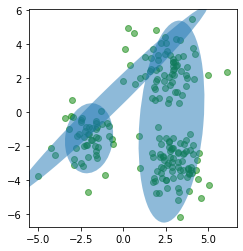

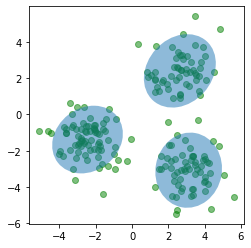

0.8178439846460034


In [9]:
aris1 = []
for xi,yi in zip(Xs,Ys):
    em = EM(xi,3)
    for _ in range(100):
        em.E_Step()
        em.M_Step()

    ax = plt.subplot(111, aspect='equal')
    for comp in range(em.k):
        lambda_, v = np.linalg.eig(em.covs[comp])
        lambda_ = np.sqrt(lambda_)

        ell = matplotlib.patches.Ellipse(xy=em.mus[comp],
                          width=lambda_[0]*2*2, height=lambda_[1]*2*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),alpha=.5)
        #     ell.set_facecolor('none')
        ax.add_artist(ell)
    ax.scatter(em.X[:,0],em.X[:,1],color="green",alpha=.5)
    plt.show()
    aris1.append(adjusted_rand_score(yi,np.argmax(em.gammas,axis=1)))
print(np.mean(aris1))

In [10]:
ems = [EM(xi,3) for xi in Xs]
NIters = 25
aris = []
LLs = np.zeros((NIters,len(Xs)))
for iteration in range(NIters):
    for i in range(len(Xs)):
        LLs[iteration,i] = ems[i].log_likelihood()
        ems[i].E_Step()
        ems[i].M_Step()
        ems[(i+1) % len(Xs)].mus = ems[i].mus
        ems[(i+1) % len(Xs)].covs = ems[i].covs
# After final iteration, update all out-of-date copies of mus and covs and also gamma 
for j in range(1,len(Xs)-1):
    ems[j].mus = ems[0].mus
    ems[j].covs = ems[0].covs
    # update gamma with new mus and covs values
    ems[j].E_Step()
# Calculate performance
for em,yi in zip(ems, Ys):
    aris.append(adjusted_rand_score(yi,np.argmax(em.gammas,axis=1)))
print(np.mean(aris))

0.9928964477575016


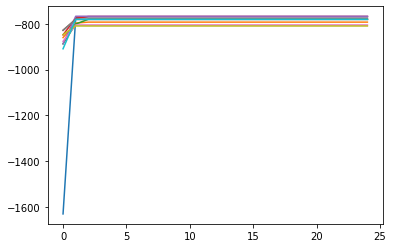

In [11]:
ax = plt.subplot(111)
for i in range(len(Xs)):
    ax.plot(LLs[:,i])

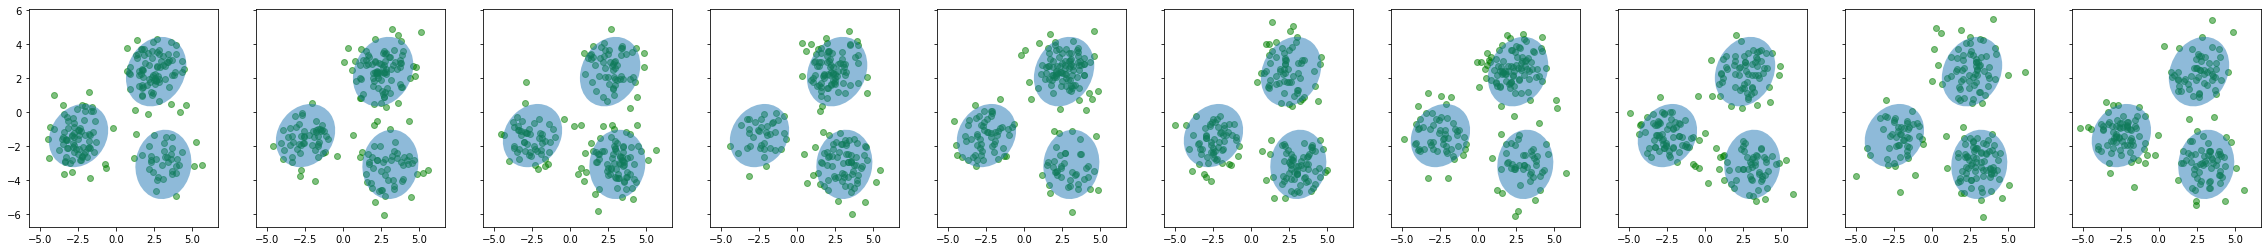

In [12]:
fig,ax = plt.subplots(1,len(Xs),figsize=(4 * len(Xs),4),sharey=True, sharex=True)
for ds_num in range(len(Xs)):
    for comp in range(ems[ds_num].k):
        lambda_, v = np.linalg.eig(ems[ds_num].covs[comp])
        lambda_ = np.sqrt(lambda_)

        ell = matplotlib.patches.Ellipse(xy=ems[ds_num].mus[comp],
                          width=lambda_[0]*2*2, height=lambda_[1]*2*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),alpha=.5)
        ax[ds_num].add_artist(ell)
    ax[ds_num].scatter(ems[ds_num].X[:,0],ems[ds_num].X[:,1],alpha=.5,color="green")
plt.show()

## Experiment Description
Here, I test whether a multi-instance clustering approach can lead to better estimates of the latent cluster assignment than separate clustering processes. While Shantanu and I thought we should compare the resulting mixing proportions, I think comparing the cluster predictions derived from the latent posterior more directly compares the values of interest. I use the [adjusted rand index](https://en.wikipedia.org/wiki/Rand_index) to compare the quality of the clusterings of the two methods.

As seen in the above experiments, the average adjusted rand index across all bags is higher when using the multi-instance clustering approach. Further, the multi-instance method ensures the estimated distributions $\phi_k$ are the same for each bag. I do not evaluate the quality of the resulting distributions and believe the quality of the gaussians degrades in high dimensions.

**Notes**
* I'm not directly comparing the quality of the latent posterior but rather the clustering estimates that those posteriors lead to
* I'm treating this evaluation as an alternative to separately comparing the quality of the latent marginal (r$^i_j$ i.e. p(z = k) ) and the fitted distributions $\phi_k$

In [187]:
class MultiEM:
    def __init__(self, bags, n_components):
        self.em_instances = []
        self.labels = []
        self.bags = bags
        # Initialize each EM instance
        for bag in self.bags:
            self.em_instances.append(EM(bag.X_pos, n_components))

    def run_positive_em(self, n_iters):
        self.logLikelihoods = np.zeros((len(self.em_instances),
                                        n_iters))
        for iteration in range(n_iters):
            for inst in range(len(self.em_instances)):
                self.logLikelihoods[inst,iteration] = self.em_instances[inst].log_likelihood()
                self.em_instances[inst].E_Step()
                self.em_instances[inst].M_Step()
                self.em_instances[(inst+1) % len(self.em_instances)].mus = self.em_instances[inst].mus
                self.em_instances[(inst+1) % len(self.em_instances)].covs = self.em_instances[inst].covs
        # After final iteration, pass mu and cov to all instances and update gammas through the E_Step
        for j in range(1,len(self.em_instances)-1):
            self.em_instances[j].mus = self.em_instances[0].mus
            self.em_instances[j].covs = self.em_instances[0].covs
            # update gamma with new mus and covs values
            self.em_instances[j].E_Step()
        self.compute_positive_clustering_performance()

    def compute_positive_clustering_performance(self):
        adjusted_rand_scores = []
        for em,bag in zip(self.em_instances, self.bags):
            adjusted_rand_scores.append(adjusted_rand_score(bag.positive_component_labels,
                                                            np.argmax(em.gammas,axis=1)))
        self.score = np.mean(adjusted_rand_scores)

    def cluster_unlabeled(self):
        for bagnum, (bag, em) in enumerate(zip(self.bags, self.em_instances)):
            assignments = np.zeros(bag.x_unlabeled.shape[0]).astype(int)
            for instnum,inst in enumerate(bag.x_unlabeled):
                lls = np.zeros(em.k)
                for i,(mu,cov) in enumerate(zip(em.mus, em.covs)):
                    lls[i] = ss.multivariate_normal.logpdf(inst,mean=mu,cov=cov)
                assignments[instnum] = np.argmax(lls)
            self.bags[bagnum].unlabeled_assignments = assignments

In [188]:
def mvn_gen(mean):
    return lambda n: np.random.multivariate_normal(mean, np.eye(len(mean)),size=n)

In [231]:
def generateBags(NBags):
    bags = []
    NPos = 200
    NUnlabeled = 10
    pos_means = [[2.5,2.5], [-2.5,-2.5], [3,-3]]
    neg_means = [[0,0]]
    pos_components = [mvn_gen(m) for m in pos_means]
    neg_components = [mvn_gen(m) for m in neg_means]
    for _ in range(NBags):
        pos_weights = np.random.dirichlet(np.ones(len(pos_components))*5)
        bag = EasyDict()
        bag.pos_weights = pos_weights
        x = []
        positive_component_labels = []
        for i,(comp,w) in enumerate(zip(pos_components,pos_weights)):
            ni = np.round(NPos * w).astype(int)
            x.append(comp(ni))
            positive_component_labels.append(np.ones(ni) * i)
        bag.X_pos = np.concatenate(x)
        bag.positive_component_labels = np.concatenate(positive_component_labels)
        alpha = np.random.beta(2,2)
        bag.alpha = alpha
        n_unlabeled_pos = np.round(NUnlabeled * alpha).astype(int)
        n_unlabeled_neg = NUnlabeled - n_unlabeled_pos
        xunlabeled = []
        unlabeled_pos_componenet_labels = []
        unlabeled_pos_weights = np.random.dirichlet(np.ones(len(pos_components)) * 5)
        for i,(comp,w) in enumerate(zip(pos_components,unlabeled_pos_weights)):
            ni = np.round(n_unlabeled_pos * w).astype(int)
            xunlabeled.append(comp(ni))
            unlabeled_pos_componenet_labels.append(np.ones(ni) * i)
        bag.unlabeled_pos_componenet_labels = unlabeled_pos_componenet_labels
        unlabeled_neg_weights = np.random.dirichlet(np.ones(len(neg_components)) * 5)
        unlabeled_neg_componenet_labels = []
        for i, (comp,w) in enumerate(zip(neg_components, unlabeled_neg_weights)):
            ni = np.round(n_unlabeled_neg * w).astype(int)
            xunlabeled.append(comp(ni))
            unlabeled_neg_componenet_labels.append(np.ones(ni) * i)
        bag.unlabeled_neg_componenet_labels = unlabeled_neg_componenet_labels
        bag.x_unlabeled = np.concatenate(xunlabeled)
        bags.append(bag)
    return bags

In [232]:
mem = MultiEM(generateBags(10),3)

In [223]:
mem.run_positive_em(5)

In [224]:
mem.score

0.522053512792129

In [225]:
mem.cluster_unlabeled()

In [234]:
mem.bags[2].x_unlabeled.shape

(10, 2)

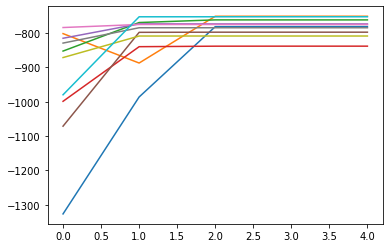

In [152]:
for l in mem.logLikelihoods:
    plt.plot(l)

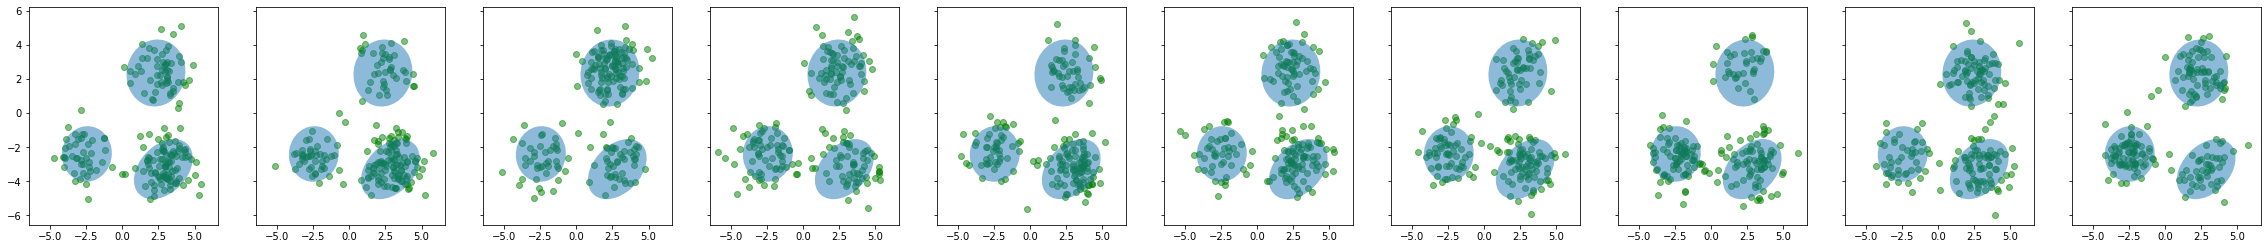

In [153]:
fig,ax = plt.subplots(1,len(mem.bags),figsize=(4 * len(mem.bags),4),sharey=True, sharex=True)
for ds_num in range(len(mem.bags)):
    for comp in range(mem.em_instances[ds_num].k):
        lambda_, v = np.linalg.eig(mem.em_instances[ds_num].covs[comp])
        lambda_ = np.sqrt(lambda_)

        ell = matplotlib.patches.Ellipse(xy=mem.em_instances[ds_num].mus[comp],
                          width=lambda_[0]*2*2, height=lambda_[1]*2*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),alpha=.5)
        ax[ds_num].add_artist(ell)
    ax[ds_num].scatter(mem.bags[ds_num].X_pos[:,0],
                       mem.bags[ds_num].X_pos[:,1],alpha=.5,color="green")
plt.show()